# 时段划分模型预测MRR
基于模态I腔室4的数据
模态I数据，分成了5个稳定时段，（1）在质量变量（MRR）的监督下，分时段训练各 LSTM 模型以提取各时段特征（2）训 练完成后，拼接各时段LSTM模型的输出向量作为SAE模型的输入（3）基于各时段 LSTM 模型的输出，SAE 首先对各自动编码器进行无监督的预训练，而后在质量变量监督下微调各层的权重和偏置

Note: LSTM没有选参数/多次实验平均值，BiLSTM没有多次实验平均值

In [1]:
import pickle
import os
import tqdm as tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import utils.functions_plot as PL

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from keras.models import Model, Input

# 0. 导入数据

In [2]:
# 导入时段数据
with open('./data phm 2016/Train_seg_X_r.dict', 'rb') as f:
    Train_seg_X = pickle.load(f)
with open('./data phm 2016/Test_seg_X_r.dict', 'rb') as f:
    Test_seg_X = pickle.load(f)
with open('./data phm 2016/Train_seg_Y_r.dict', 'rb') as f:
    Train_seg_Y = pickle.load(f)
with open('./data phm 2016/Test_seg_Y_r.dict', 'rb') as f:
    Test_seg_Y = pickle.load(f)

In [3]:
# 验证导入的数据是合理的
for i in range(0,5):
    print(Train_seg_X.get(f'seg_{i}').shape, len(Train_seg_Y.get(f'seg_{i}')), Test_seg_X.get(f'seg_{i}').shape, len(Test_seg_Y.get(f'seg_{i}')))

(797, 37, 19) 797 (165, 37, 19) 165
(797, 147, 19) 797 (165, 147, 19) 165
(797, 42, 19) 797 (165, 42, 19) 165
(797, 21, 19) 797 (165, 21, 19) 165
(797, 93, 19) 797 (165, 93, 19) 165


In [4]:
max_batch_length = [Train_seg_X.get(f'seg_{i}').shape[1] for i in range(0,5)]
variable_number = Train_seg_X.get(f'seg_0').shape[2]
print(max_batch_length, variable_number)

[37, 147, 42, 21, 93] 19


# 1. common function

In [5]:
def fit_and_pre(model_lstm, X_train, Y_train, X_test, Y_test, n_epoch=200, batch_size=200, standard_flag=True, reduce_lr=False, verbose=1, show_figure=True):
    # 归一化
    if standard_flag:
        ss = StandardScaler()
        Y_train = ss.fit_transform(Y_train) 
    
    if reduce_lr:
        # EarlyStop=EarlyStopping(monitor='mse', patience=2,verbose=1, mode='min')
        Reduce = ReduceLROnPlateau(monitor='mse',
                                 factor=0.5,
                                 patience=10,
                                 verbose=1,
                                 mode='auto',
                                 min_delta=0.05, # 0.0001
                                 cooldown=0,
                                 min_lr=1e-10)
        history_lstm = model_lstm.fit(X_train, Y_train, epochs=n_epoch, batch_size=batch_size, callbacks=[Reduce], verbose=verbose) 
    else:
        history_lstm = model_lstm.fit(X_train, Y_train, epochs=n_epoch, batch_size=batch_size, verbose=verbose) 
    
    Y_train_pre = model_lstm.predict(X_train)
    
    if standard_flag:
        Y_train_pre = ss.inverse_transform(Y_train_pre)
        Y_train = ss.inverse_transform(Y_train)
    
    print('Train Set Fit result:')
    PL.plot_predict_curve(Y_train, Y_train_pre, show_figure=show_figure)
    
    Y_test_pre = model_lstm.predict(X_test)
    
    if standard_flag==True:
        Y_test_pre = ss.inverse_transform(Y_test_pre)
    
    print('Test Set Prediction result:')
    PL.plot_predict_curve(Y_test, Y_test_pre, show_figure=show_figure)

# 2.1 分时段提取特征- LSTM
在质量变量（MRR）的监督下，分时段训练各 LSTM 模型以提取各时段特征

In [6]:
# LSTM模型
# 导入必要的库
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, BatchNormalization, Flatten
from keras.optimizers import Adam, Adagrad, RMSprop
from keras.callbacks import ReduceLROnPlateau

In [34]:
# LSTM模型(segment0~3采用40有dense1-tanh有y值归一化，segment4的units=20没有采用dense1-relu没有y值归一化)
# segment4执行起来特殊，振荡
def init_LSTM_model(max_batch_length, variable_number, learning_rate=0.001, print_model=True):
    model_lstm = Sequential(name='sequential_lstm')
    model_lstm.add(LSTM(input_shape=(max_batch_length,variable_number), units=40, activation='tanh', return_sequences=True, name='lstm1'))
    model_lstm.add(LSTM(units=40, activation='tanh', return_sequences=False, name='lstm2'))

    model_lstm.add(Dense(4, name='dense1'))
    model_lstm.add(Dense(1, name='dense2'))
    
    if print_model:
        print(model_lstm.summary())
    
    adam = Adam(learning_rate=learning_rate)
    rmsprop = RMSprop(learning_rate=learning_rate)
    model_lstm.compile(loss='mse', optimizer=adam, metrics=['mse']) # rmsprop
    
    return model_lstm

Model: "sequential_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm1 (LSTM)                 (None, 37, 40)            9600      
_________________________________________________________________
lstm2 (LSTM)                 (None, 40)                12960     
_________________________________________________________________
dense1 (Dense)               (None, 4)                 164       
_________________________________________________________________
dense2 (Dense)               (None, 1)                 5         
Total params: 22,729
Trainable params: 22,729
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
16/16 [==============================] - 3s 17ms/step - loss: 1.0120 - mse: 1.0120
Epoch 2/200
16/16 [==============================] - 0s 16ms/step - loss: 1.0810 - mse: 1.0810
Epoch 3/200
16/16 [==============================]

16/16 [==============================] - 0s 15ms/step - loss: 0.2557 - mse: 0.2557
Epoch 162/200
16/16 [==============================] - 0s 15ms/step - loss: 0.2117 - mse: 0.2117
Epoch 163/200
16/16 [==============================] - 0s 15ms/step - loss: 0.2594 - mse: 0.2594
Epoch 164/200
16/16 [==============================] - 0s 15ms/step - loss: 0.2246 - mse: 0.2246
Epoch 165/200
16/16 [==============================] - 0s 15ms/step - loss: 0.2116 - mse: 0.2116
Epoch 166/200
16/16 [==============================] - 0s 15ms/step - loss: 0.2325 - mse: 0.2325
Epoch 167/200
16/16 [==============================] - 0s 15ms/step - loss: 0.2187 - mse: 0.2187
Epoch 168/200
16/16 [==============================] - 0s 15ms/step - loss: 0.2228 - mse: 0.2228
Epoch 169/200
16/16 [==============================] - 0s 15ms/step - loss: 0.2655 - mse: 0.2655
Epoch 170/200
16/16 [==============================] - 0s 15ms/step - loss: 0.2330 - mse: 0.2330
Epoch 171/200
16/16 [=======================

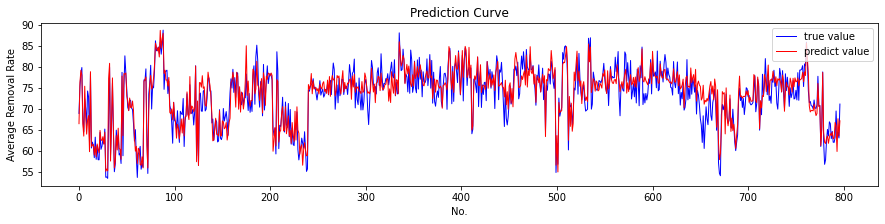

Test Set Prediction result:
MSE:  11.195790535385092
RMSE:  3.346011137964889
MAE:  2.628415324337123
R^2:  0.7284135175088938
max absolute error:  9.550035949707052
min absolute error:  0.08046246337887908
mean absolute error:  2.628415324337123




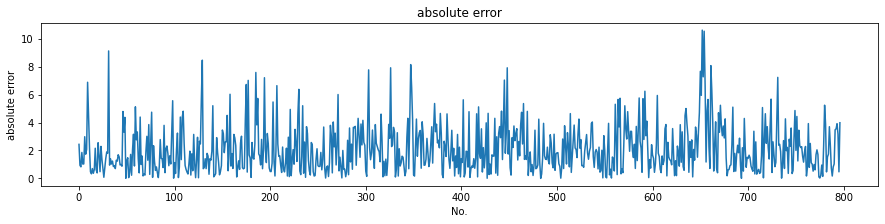

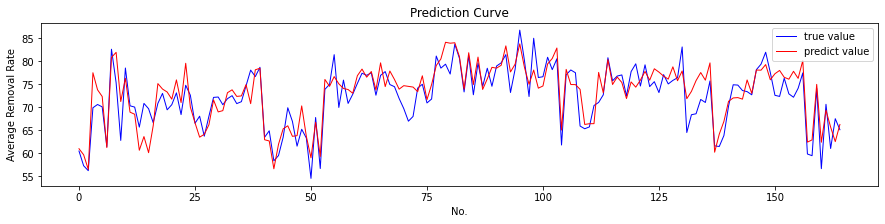

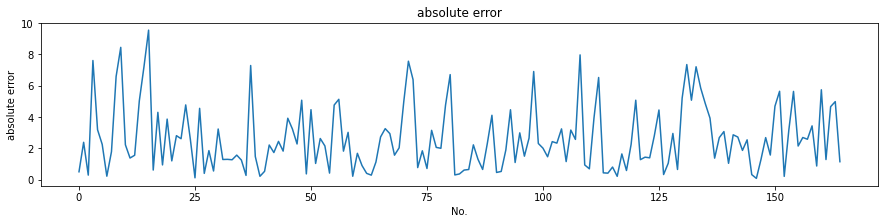

In [10]:
for i in [0]: #range(0,5):
    X_train = Train_seg_X[f'seg_{i}']
    X_test = Test_seg_X[f'seg_{i}']
    
    Y_train = np.reshape(Train_seg_Y[f'seg_{i}'], (-1,1))
    Y_test = np.reshape(Test_seg_Y[f'seg_{i}'], (-1,1))
    
    model_lstm = init_LSTM_model(max_batch_length=max_batch_length[i], variable_number=variable_number, learning_rate=0.001)
    
    fit_and_pre(model_lstm, X_train, Y_train, X_test, Y_test, n_epoch=200, batch_size=50) # batch_size最好的结果

Model: "sequential_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm1 (LSTM)                 (None, 147, 40)           9600      
_________________________________________________________________
lstm2 (LSTM)                 (None, 40)                12960     
_________________________________________________________________
dense1 (Dense)               (None, 4)                 164       
_________________________________________________________________
dense2 (Dense)               (None, 1)                 5         
Total params: 22,729
Trainable params: 22,729
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
4/4 [==============================] - 12s 118ms/step - loss: 0.9949 - mse: 0.9949
Epoch 2/200
4/4 [==============================] - 0s 120ms/step - loss: 1.0158 - mse: 1.0158
Epoch 3/200
4/4 [==============================] - 

Epoch 78/200
4/4 [==============================] - 0s 125ms/step - loss: 0.2685 - mse: 0.2685
Epoch 79/200
4/4 [==============================] - 0s 118ms/step - loss: 0.2603 - mse: 0.2603
Epoch 80/200
4/4 [==============================] - 0s 122ms/step - loss: 0.2298 - mse: 0.2298
Epoch 81/200
4/4 [==============================] - 0s 126ms/step - loss: 0.2511 - mse: 0.2511
Epoch 82/200
4/4 [==============================] - 0s 116ms/step - loss: 0.2584 - mse: 0.2584
Epoch 83/200
4/4 [==============================] - 0s 114ms/step - loss: 0.2698 - mse: 0.2698
Epoch 84/200
4/4 [==============================] - 0s 118ms/step - loss: 0.2489 - mse: 0.2489
Epoch 85/200
4/4 [==============================] - 0s 117ms/step - loss: 0.2483 - mse: 0.2483
Epoch 86/200
4/4 [==============================] - 0s 114ms/step - loss: 0.2551 - mse: 0.2551
Epoch 87/200
4/4 [==============================] - 0s 118ms/step - loss: 0.2578 - mse: 0.2578
Epoch 88/200
4/4 [==============================] 

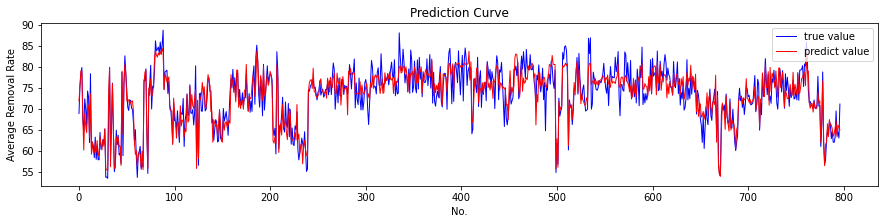

Test Set Prediction result:
MSE:  10.616493639361074
RMSE:  3.258296125179704
MAE:  2.552145368726319
R^2:  0.7424660496469266
max absolute error:  11.906193505859207
min absolute error:  0.06155124511701615
mean absolute error:  2.552145368726319




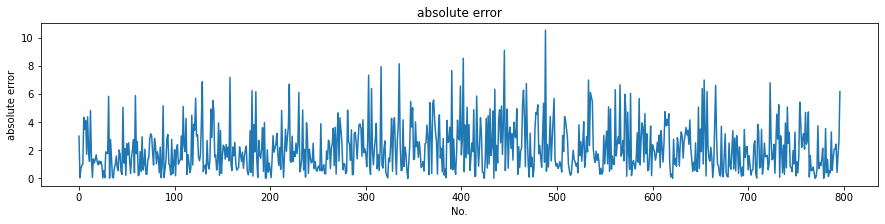

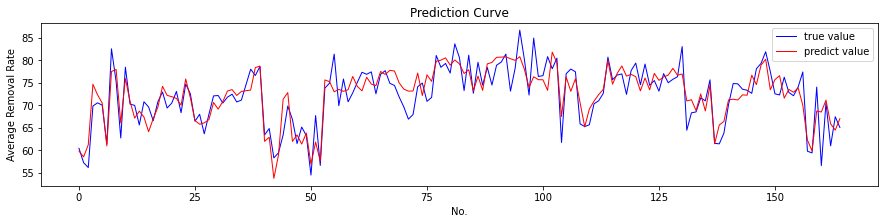

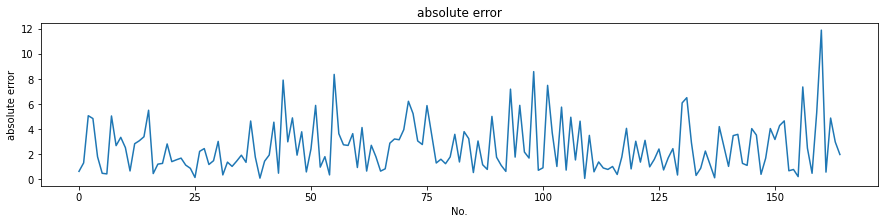

In [8]:
for i in [1]:
    X_train = Train_seg_X[f'seg_{i}']
    X_test = Test_seg_X[f'seg_{i}']
    
    Y_train = np.reshape(Train_seg_Y[f'seg_{i}'], (-1,1))
    Y_test = np.reshape(Test_seg_Y[f'seg_{i}'], (-1,1))
    
    model_lstm = init_LSTM_model(max_batch_length=max_batch_length[i], variable_number=variable_number, learning_rate=0.001)
    
    fit_and_pre(model_lstm, X_train, Y_train, X_test, Y_test)


Model: "sequential_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm1 (LSTM)                 (None, 42, 40)            9600      
_________________________________________________________________
lstm2 (LSTM)                 (None, 40)                12960     
_________________________________________________________________
dense1 (Dense)               (None, 4)                 164       
_________________________________________________________________
dense2 (Dense)               (None, 1)                 5         
Total params: 22,729
Trainable params: 22,729
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
8/8 [==============================] - 3s 26ms/step - loss: 1.0230 - mse: 1.0230
Epoch 2/150
8/8 [==============================] - 0s 23ms/step - loss: 0.9483 - mse: 0.9483
Epoch 3/150
8/8 [==============================] - 0s 

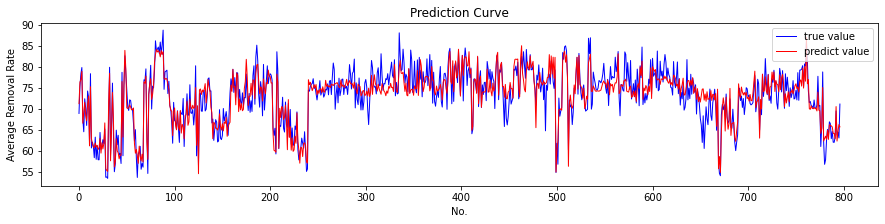

Test Set Prediction result:
MSE:  4933.2671200916875
RMSE:  70.23722033289535
MAE:  8.5557731426817
R^2:  -118.67075126139336
max absolute error:  900.5473294921875
min absolute error:  0.021213525390592736
mean absolute error:  8.5557731426817




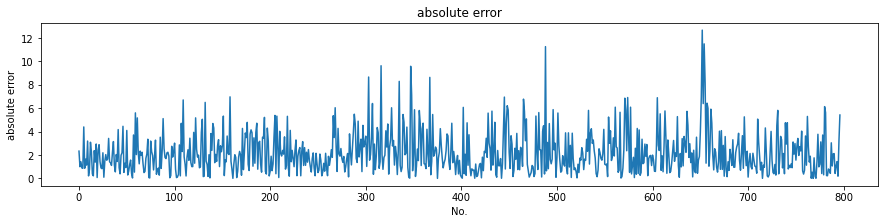

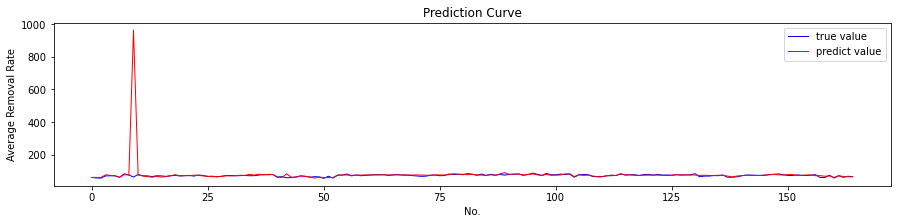

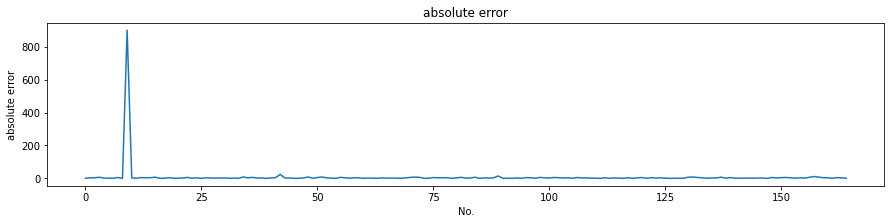

In [9]:
for i in [2]:
    X_train = Train_seg_X[f'seg_{i}']
    X_test = Test_seg_X[f'seg_{i}']
    
    Y_train = np.reshape(Train_seg_Y[f'seg_{i}'], (-1,1))
    Y_test = np.reshape(Test_seg_Y[f'seg_{i}'], (-1,1))
    
    model_lstm = init_LSTM_model(max_batch_length=max_batch_length[i], variable_number=variable_number, learning_rate=0.001)
    
    fit_and_pre(model_lstm, X_train, Y_train, X_test, Y_test, n_epoch=150, batch_size=100) 
    # 不太好的超参数200&100 mse=17, 200&150 mse=13, 200&200 mse=12, 200&300 mse=14
    # 不太好的超参数400&200 mse=17 100&200 mse=15 180&200 mse=14
    # 150&100 mse=11.45

Model: "sequential_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm1 (LSTM)                 (None, 21, 40)            9600      
_________________________________________________________________
lstm2 (LSTM)                 (None, 40)                12960     
_________________________________________________________________
dense1 (Dense)               (None, 4)                 164       
_________________________________________________________________
dense2 (Dense)               (None, 1)                 5         
Total params: 22,729
Trainable params: 22,729
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
16/16 [==============================] - 3s 12ms/step - loss: 1.0151 - mse: 1.0151
Epoch 2/200
16/16 [==============================] - 0s 10ms/step - loss: 0.7776 - mse: 0.7776
Epoch 3/200
16/16 [==============================]

16/16 [==============================] - 0s 10ms/step - loss: 0.1735 - mse: 0.1735
Epoch 162/200
16/16 [==============================] - 0s 10ms/step - loss: 0.1699 - mse: 0.1699
Epoch 163/200
16/16 [==============================] - 0s 10ms/step - loss: 0.1776 - mse: 0.1776
Epoch 164/200
16/16 [==============================] - 0s 10ms/step - loss: 0.1729 - mse: 0.1729
Epoch 165/200
16/16 [==============================] - 0s 10ms/step - loss: 0.2072 - mse: 0.2072
Epoch 166/200
16/16 [==============================] - 0s 10ms/step - loss: 0.1836 - mse: 0.1836
Epoch 167/200
16/16 [==============================] - 0s 10ms/step - loss: 0.1590 - mse: 0.1590
Epoch 168/200
16/16 [==============================] - 0s 10ms/step - loss: 0.1722 - mse: 0.1722
Epoch 169/200
16/16 [==============================] - 0s 10ms/step - loss: 0.1616 - mse: 0.1616
Epoch 170/200
16/16 [==============================] - 0s 10ms/step - loss: 0.1530 - mse: 0.1530
Epoch 171/200
16/16 [=======================

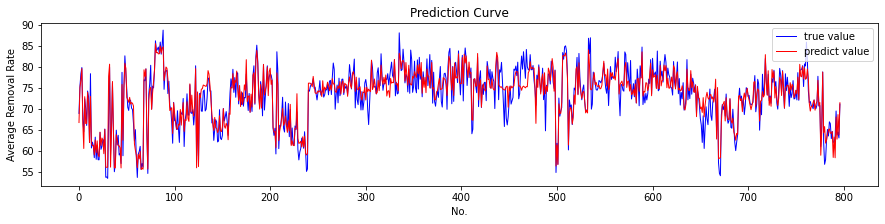

Test Set Prediction result:
MSE:  11.934869381081771
RMSE:  3.4546880294871447
MAE:  2.67996987141927
R^2:  0.7104850091689114
max absolute error:  11.839451379394532
min absolute error:  0.003877514648451097
mean absolute error:  2.67996987141927




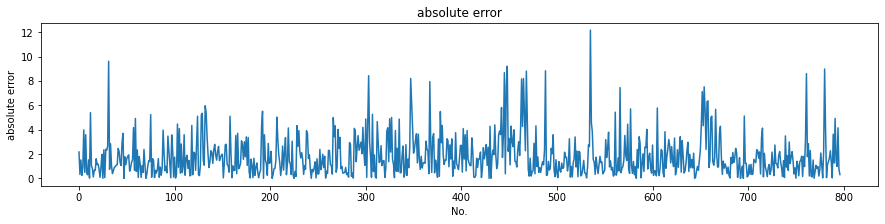

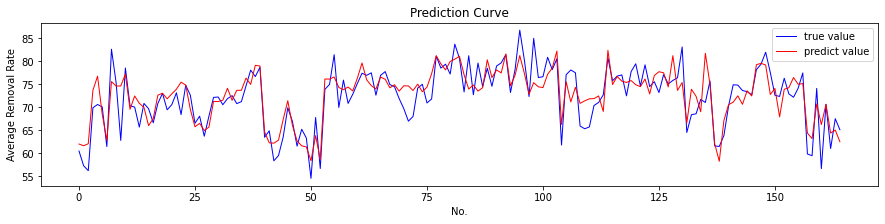

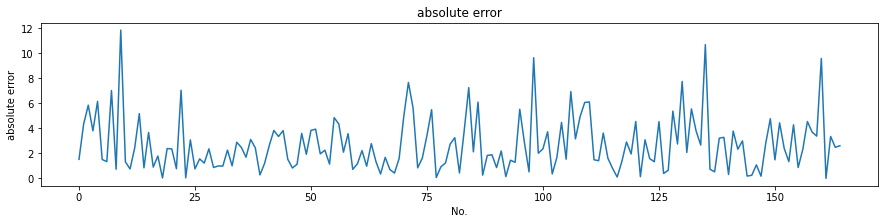

In [17]:
for i in [3]:
    X_train = Train_seg_X[f'seg_{i}']
    X_test = Test_seg_X[f'seg_{i}']
    
    Y_train = np.reshape(Train_seg_Y[f'seg_{i}'], (-1,1))
    Y_test = np.reshape(Test_seg_Y[f'seg_{i}'], (-1,1))
    
    model_lstm = init_LSTM_model(max_batch_length=max_batch_length[i], variable_number=variable_number, learning_rate=0.001)
    
    fit_and_pre(model_lstm, X_train, Y_train, X_test, Y_test, n_epoch=200, batch_size=50) # 40&200&10 mse=14 40&200&200 or 100 mse=12 40&200&50 mse=11.1

Model: "sequential_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm1 (LSTM)                 (None, 93, 20)            3200      
_________________________________________________________________
lstm2 (LSTM)                 (None, 20)                3280      
_________________________________________________________________
dense2 (Dense)               (None, 1)                 21        
Total params: 6,501
Trainable params: 6,501
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
8/8 [==============================] - 3s 37ms/step - loss: 5323.6341 - mse: 5323.6341
Epoch 2/200
8/8 [==============================] - 0s 36ms/step - loss: 5285.2983 - mse: 5285.2983
Epoch 3/200
8/8 [==============================] - 0s 37ms/step - loss: 5130.1860 - mse: 5130.1860
Epoch 4/200
8/8 [==============================] - 0s 37ms/step - loss: 4864.

Epoch 78/200
8/8 [==============================] - 0s 37ms/step - loss: 18.9268 - mse: 18.9268
Epoch 79/200
8/8 [==============================] - 0s 36ms/step - loss: 19.7366 - mse: 19.7366
Epoch 80/200
8/8 [==============================] - 0s 36ms/step - loss: 19.4209 - mse: 19.4209
Epoch 81/200
8/8 [==============================] - 0s 36ms/step - loss: 18.7467 - mse: 18.7467
Epoch 82/200
8/8 [==============================] - 0s 36ms/step - loss: 18.6467 - mse: 18.6467
Epoch 83/200
8/8 [==============================] - 0s 37ms/step - loss: 19.2128 - mse: 19.2128
Epoch 84/200
8/8 [==============================] - 0s 37ms/step - loss: 18.2132 - mse: 18.2132
Epoch 85/200
8/8 [==============================] - 0s 36ms/step - loss: 18.5908 - mse: 18.5908
Epoch 86/200
8/8 [==============================] - 0s 36ms/step - loss: 18.7064 - mse: 18.7064
Epoch 87/200
8/8 [==============================] - 0s 36ms/step - loss: 19.5542 - mse: 19.5542
Epoch 88/200
8/8 [======================

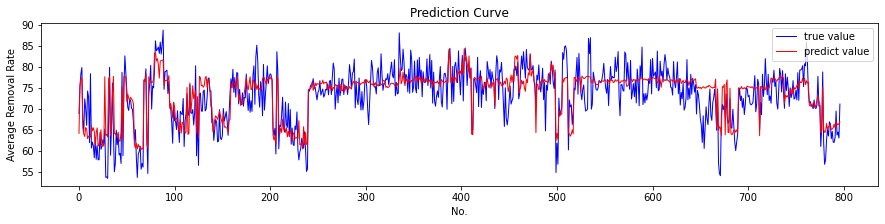

Test Set Prediction result:
MSE:  15.003858890738305
RMSE:  3.873481494823269
MAE:  2.9656136393599084
R^2:  0.6360377369467847
max absolute error:  12.98280770263672
min absolute error:  0.03387800292968279
mean absolute error:  2.9656136393599084




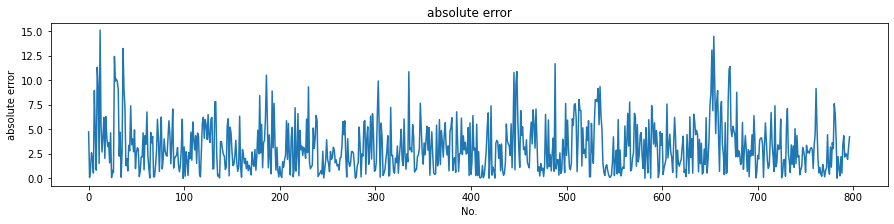

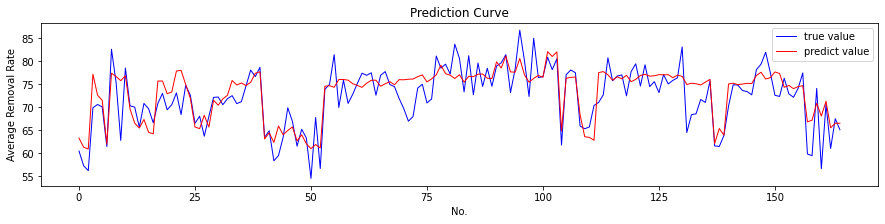

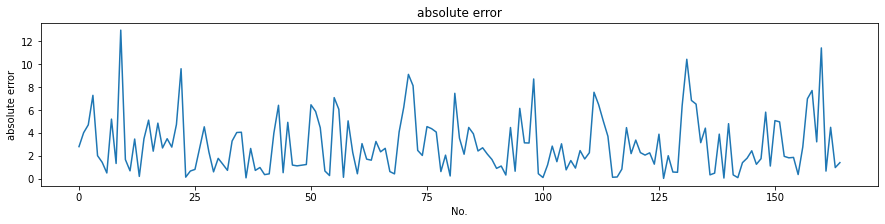

In [32]:
for i in [4]:
    X_train = Train_seg_X[f'seg_{i}']
    X_test = Test_seg_X[f'seg_{i}']
    
    Y_train = np.reshape(Train_seg_Y[f'seg_{i}'], (-1,1))
    Y_test = np.reshape(Test_seg_Y[f'seg_{i}'], (-1,1))
    
    model_lstm = init_LSTM_model(max_batch_length=max_batch_length[i], variable_number=variable_number, learning_rate=0.001)
    
    fit_and_pre(model_lstm, X_train, Y_train, X_test, Y_test, n_epoch=200, batch_size=100, standard_flag=False)

In [33]:
# 单独保存segment4
i = 4
layer_lstm2 = model_lstm.get_layer('lstm2').output
intermediate_layer_model = Model(inputs=model_lstm.input, outputs=layer_lstm2)

# pre train and test for 2nd hidden layer
lstm2_output_train = intermediate_layer_model.predict(X_train)
lstm2_output_test = intermediate_layer_model.predict(X_test)

model_lstm.save(f'./save_model/segment_{i}_model_lstm.h5')
pickle.dump(lstm2_output_train, open(f'./data phm 2016/lstm_output_train_segment_{i}.array', 'wb'))
pickle.dump(lstm2_output_test, open(f'./data phm 2016/lstm_output_test_segment_{i}.array', 'wb'))

# 2.2 分时段提取特征-BiLSTM模型

In [10]:
# 导入必要的库
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Activation, BatchNormalization, Flatten
from keras.optimizers import Adam, Adagrad
from keras.callbacks import ReduceLROnPlateau

In [11]:
# 网络结构
def init_biLSTM_model(max_batch_length, variable_number, learning_rate=0.001, print_model=True):
    model_biLSTM = Sequential(name='model_biLSTM')
    model_biLSTM.add(Bidirectional(LSTM(units=40, activation='tanh', return_sequences=True), input_shape=(max_batch_length,variable_number), name='biLSTM1'))
    model_biLSTM.add(Bidirectional(LSTM(units=40, activation='tanh', return_sequences=False), name='biLSTM2'))


    model_biLSTM.add(Dense(4, name='dense1'))
    model_biLSTM.add(Dense(1, name='dense2'))
    
    if print_model:
        print(model_biLSTM.summary())

    adam = Adam(learning_rate=learning_rate)
    model_biLSTM.compile(loss='mse', optimizer=adam, metrics=['mse']) # rmsprop

    return model_biLSTM

## 网格搜索+BiLSTM选参数

In [11]:
i = 0
X_train = Train_seg_X[f'seg_{i}']
X_test = Test_seg_X[f'seg_{i}']

Y_train = np.reshape(Train_seg_Y[f'seg_{i}'], (-1,1))
Y_test = np.reshape(Test_seg_Y[f'seg_{i}'], (-1,1))

n_epoch = [50, 100, 150, 200]
batch_size = [50, 100, 150, 200]
grid = ParameterGrid(dict(n_epoch=n_epoch, batch_size=batch_size))

for params in grid:
    model_biLSTM = init_biLSTM_model(max_batch_length=max_batch_length[i], variable_number=variable_number, learning_rate=0.001, print_model=False)
    
    print('------------\n')
    print(params)
    fit_and_pre(model_biLSTM, X_train, Y_train, X_test, Y_test, verbose=0, show_figure=False, **params)
    
    # best n_epoch&batch_size 200&200 11.56

------------

{'batch_size': 50, 'n_epoch': 50}
Train Set Fit result:
MSE:  9.959449121394252
RMSE:  3.155859490122184
MAE:  2.4594425203521997
R^2:  0.7750292675521572
max absolute error:  10.450780822753913
min absolute error:  0.008723083496093409
mean absolute error:  2.4594425203521997


Test Set Prediction result:
MSE:  13.873080489177399
RMSE:  3.7246584392635786
MAE:  2.983449196148498
R^2:  0.6634680579755873
max absolute error:  12.301685876464845
min absolute error:  0.08981614990234732
mean absolute error:  2.983449196148498


------------

{'batch_size': 50, 'n_epoch': 100}
Train Set Fit result:
MSE:  5.910387262783384
RMSE:  2.4311288042354695
MAE:  1.851294213423017
R^2:  0.8664921989809176
max absolute error:  9.260946142578135
min absolute error:  0.0003658691406229764
mean absolute error:  1.851294213423017


Test Set Prediction result:
MSE:  13.262223627089362
RMSE:  3.6417336018837734
MAE:  2.712970368541373
R^2:  0.67828616893932
max absolute error:  17.18156124267

------------

{'batch_size': 200, 'n_epoch': 200}
Train Set Fit result:
MSE:  6.210360869772538
RMSE:  2.4920595638492546
MAE:  1.8883660110377907
R^2:  0.8597161934753115
max absolute error:  9.482082934570343
min absolute error:  0.003691162109376478
mean absolute error:  1.8883660110377907


Test Set Prediction result:
MSE:  11.564636106831724
RMSE:  3.400681712073584
MAE:  2.663937156353577
R^2:  0.7194660947239635
max absolute error:  13.44124276123047
min absolute error:  0.018713256835951597
mean absolute error:  2.663937156353577




In [16]:
i = 1
X_train = Train_seg_X[f'seg_{i}']
X_test = Test_seg_X[f'seg_{i}']

Y_train = np.reshape(Train_seg_Y[f'seg_{i}'], (-1,1))
Y_test = np.reshape(Test_seg_Y[f'seg_{i}'], (-1,1))

n_epoch = [50, 100, 150, 200]
batch_size = [50, 100, 150, 200]
grid = ParameterGrid(dict(n_epoch=n_epoch, batch_size=batch_size))

for params in grid:
    model_biLSTM = init_biLSTM_model(max_batch_length=max_batch_length[i], variable_number=variable_number, learning_rate=0.001, print_model=False)
    
    print('------------\n')
    print(params)
    fit_and_pre(model_biLSTM, X_train, Y_train, X_test, Y_test, verbose=0, show_figure=False, **params)
    
    # best n_epoch&batch_size 100&50 11.29

------------

{'batch_size': 50, 'n_epoch': 50}
Train Set Fit result:
MSE:  8.990294754920619
RMSE:  2.998382022845091
MAE:  2.341354193995914
R^2:  0.7969211779402764
max absolute error:  11.820889086913908
min absolute error:  0.008913616943516445
mean absolute error:  2.341354193995914


Test Set Prediction result:
MSE:  12.113741693740776
RMSE:  3.4804800952944372
MAE:  2.762755481955779
R^2:  0.7061459406541364
max absolute error:  13.456272668457117
min absolute error:  0.13238588867176304
mean absolute error:  2.762755481955779


------------

{'batch_size': 50, 'n_epoch': 100}
Train Set Fit result:
MSE:  5.481366691571827
RMSE:  2.3412318747983565
MAE:  1.8253783720124133
R^2:  0.8761832040720849
max absolute error:  9.287692541503922
min absolute error:  0.003356481933437294
mean absolute error:  1.8253783720124133


Test Set Prediction result:
MSE:  11.290328500078866
RMSE:  3.3601084060010424
MAE:  2.6344567024739582
R^2:  0.7261202240418627
max absolute error:  12.879002160

------------

{'batch_size': 200, 'n_epoch': 200}
Train Set Fit result:
MSE:  4.306784528331048
RMSE:  2.0752793856083684
MAE:  1.575093029172501
R^2:  0.902715455641784
max absolute error:  8.727535815429533
min absolute error:  0.004920825195071643
mean absolute error:  1.575093029172501


Test Set Prediction result:
MSE:  15.862465713117713
RMSE:  3.982771109807556
MAE:  3.0985626236979003
R^2:  0.6152097296706676
max absolute error:  16.850529260253992
min absolute error:  0.027321258545029536
mean absolute error:  3.0985626236979003




In [13]:
i = 2
X_train = Train_seg_X[f'seg_{i}']
X_test = Test_seg_X[f'seg_{i}']

Y_train = np.reshape(Train_seg_Y[f'seg_{i}'], (-1,1))
Y_test = np.reshape(Test_seg_Y[f'seg_{i}'], (-1,1))

n_epoch = [50, 100, 150, 200]
batch_size = [50, 100, 150, 200]
grid = ParameterGrid(dict(n_epoch=n_epoch, batch_size=batch_size))

for params in grid:
    model_biLSTM = init_biLSTM_model(max_batch_length=max_batch_length[i], variable_number=variable_number, learning_rate=0.001, print_model=False)
    
    print('------------\n')
    print(params)
    fit_and_pre(model_biLSTM, X_train, Y_train, X_test, Y_test, verbose=0, show_figure=False, **params)
    #best n_epoch&batch_size 100&200 13.98

------------

{'batch_size': 50, 'n_epoch': 50}
Train Set Fit result:
MSE:  10.976961890562363
RMSE:  3.3131498442663836
MAE:  2.5836117185049403
R^2:  0.7520450050528336
max absolute error:  10.95588359375003
min absolute error:  0.015841198730441874
mean absolute error:  2.5836117185049403


Test Set Prediction result:
MSE:  15.229567106696116
RMSE:  3.9025077971345703
MAE:  3.0317871627900104
R^2:  0.6305625272911928
max absolute error:  18.229992456054703
min absolute error:  0.02823167724611153
mean absolute error:  3.0317871627900104


------------

{'batch_size': 50, 'n_epoch': 100}
Train Set Fit result:
MSE:  5.879263250711053
RMSE:  2.4247192106945192
MAE:  1.8909204538610973
R^2:  0.8671952490901437
max absolute error:  9.046871752929718
min absolute error:  0.0010442749023553688
mean absolute error:  1.8909204538610973


Test Set Prediction result:
MSE:  14.871389557444214
RMSE:  3.856344066268493
MAE:  2.939737653327712
R^2:  0.6392511661506963
max absolute error:  17.95980

------------

{'batch_size': 200, 'n_epoch': 200}
Train Set Fit result:
MSE:  4.0499657752502705
RMSE:  2.012452676524412
MAE:  1.558588053245017
R^2:  0.9085166502944896
max absolute error:  8.057720751953156
min absolute error:  0.005070727539063569
mean absolute error:  1.558588053245017


Test Set Prediction result:
MSE:  16.625289955906528
RMSE:  4.07741216409459
MAE:  2.915186443795869
R^2:  0.5967052076180999
max absolute error:  23.37725502929689
min absolute error:  0.002266516113266448
mean absolute error:  2.915186443795869




In [14]:
i = 3
X_train = Train_seg_X[f'seg_{i}']
X_test = Test_seg_X[f'seg_{i}']

Y_train = np.reshape(Train_seg_Y[f'seg_{i}'], (-1,1))
Y_test = np.reshape(Test_seg_Y[f'seg_{i}'], (-1,1))

n_epoch = [50, 100, 150, 200]
batch_size = [50, 100, 150, 200]
grid = ParameterGrid(dict(n_epoch=n_epoch, batch_size=batch_size))

for params in grid:
    model_biLSTM = init_biLSTM_model(max_batch_length=max_batch_length[i], variable_number=variable_number, learning_rate=0.001, print_model=False)
    
    print('------------\n')
    print(params)
    fit_and_pre(model_biLSTM, X_train, Y_train, X_test, Y_test, verbose=0, show_figure=False, **params)
    
    # best n_epoch&batch_size 150&50 10.89

------------

{'batch_size': 50, 'n_epoch': 50}
Train Set Fit result:
MSE:  12.072918194951102
RMSE:  3.4746105098199283
MAE:  2.6873264814771707
R^2:  0.7272888072427032
max absolute error:  11.742880395507797
min absolute error:  0.0010295654296896828
mean absolute error:  2.6873264814771707


Test Set Prediction result:
MSE:  13.153382320517206
RMSE:  3.6267592035475977
MAE:  2.831310964651396
R^2:  0.6809264315905585
max absolute error:  13.390988122558603
min absolute error:  0.029277478027339043
mean absolute error:  2.831310964651396


------------

{'batch_size': 50, 'n_epoch': 100}
Train Set Fit result:
MSE:  8.794495670255674
RMSE:  2.965551495127959
MAE:  2.251714012201518
R^2:  0.8013440192995509
max absolute error:  11.905548693847663
min absolute error:  0.00228459472656084
mean absolute error:  2.251714012201518


Test Set Prediction result:
MSE:  13.112006526214788
RMSE:  3.621050472751628
MAE:  2.8020485410008282
R^2:  0.6819301218971389
max absolute error:  14.7193494

Train Set Fit result:
MSE:  8.168941105154229
RMSE:  2.8581359493827843
MAE:  2.1881456449233454
R^2:  0.815474466373642
max absolute error:  11.163197131347673
min absolute error:  0.006484460449215135
mean absolute error:  2.1881456449233454


Test Set Prediction result:
MSE:  12.013570721452567
RMSE:  3.4660598265829985
MAE:  2.7047480621522846
R^2:  0.7085758791140855
max absolute error:  12.220664343261703
min absolute error:  0.004823913574213634
mean absolute error:  2.7047480621522846




In [15]:
i = 4
X_train = Train_seg_X[f'seg_{i}']
X_test = Test_seg_X[f'seg_{i}']

Y_train = np.reshape(Train_seg_Y[f'seg_{i}'], (-1,1))
Y_test = np.reshape(Test_seg_Y[f'seg_{i}'], (-1,1))

n_epoch = [50, 100, 150, 200]
batch_size = [50, 100, 150, 200]
grid = ParameterGrid(dict(n_epoch=n_epoch, batch_size=batch_size))

for params in grid:
    model_biLSTM = init_biLSTM_model(max_batch_length=max_batch_length[i], variable_number=variable_number, learning_rate=0.001, print_model=False)
    
    print('------------\n')
    print(params)
    fit_and_pre(model_biLSTM, X_train, Y_train, X_test, Y_test, verbose=0, show_figure=False, **params)
    
    # best n_epoch&batch_size 150&100 9.88

------------

{'batch_size': 50, 'n_epoch': 50}
Train Set Fit result:
MSE:  11.253034539923496
RMSE:  3.354554298252377
MAE:  2.614503136793494
R^2:  0.7458088904466379
max absolute error:  12.352161975097687
min absolute error:  0.007214135742181327
mean absolute error:  2.614503136793494


Test Set Prediction result:
MSE:  12.806974307019336
RMSE:  3.578683320303619
MAE:  2.79512078565193
R^2:  0.6893295661075247
max absolute error:  13.29616219482422
min absolute error:  0.01354478759765243
mean absolute error:  2.79512078565193


------------

{'batch_size': 50, 'n_epoch': 100}
Train Set Fit result:
MSE:  8.94755856010658
RMSE:  2.991246990822821
MAE:  2.306349325718515
R^2:  0.7978865318400918
max absolute error:  12.821568103027374
min absolute error:  0.004872753906269622
mean absolute error:  2.306349325718515


Test Set Prediction result:
MSE:  13.783158245081069
RMSE:  3.7125676081495227
MAE:  2.821872645448628
R^2:  0.6656493837064181
max absolute error:  14.93178231201172
m

------------

{'batch_size': 200, 'n_epoch': 200}
Train Set Fit result:
MSE:  7.727203933753863
RMSE:  2.779784871847795
MAE:  2.140015937680731
R^2:  0.8254527225791886
max absolute error:  11.490894885253937
min absolute error:  0.0018393493652339998
mean absolute error:  2.140015937680731


Test Set Prediction result:
MSE:  11.595817672750979
RMSE:  3.405263231051453
MAE:  2.640818919344817
R^2:  0.7187096950950306
max absolute error:  12.375797814941407
min absolute error:  0.0068226318359307925
mean absolute error:  2.640818919344817




# 2.3 分时段提取特征-conv1d模型

In [12]:
# load deeplearning packages
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D
from keras.optimizers import SGD

In [183]:
# conv1d模型参数来自文兰论文表5.2的修改，时段3的fiters=[64,32,16],pool_size=[4,2,1]，其它时段的fiters=[64,32,16],pool_size=[4,2,2]
def init_conv1d_model(max_batch_length, variable_number, learning_rate=0.1, print_model=True):
    model = Sequential(name='model_conv1d')
    model.add(Convolution1D(filters=64, kernel_size=2, activation='relu', input_shape=(max_batch_length, variable_number), name='conv1d1'))
    model.add(MaxPooling1D(4, name='maxpool1'))
    model.add(Convolution1D(filters=32, kernel_size=2, activation='relu', name='conv1d2'))
    model.add(MaxPooling1D(2, name='maxpool2'))
    model.add(Convolution1D(filters=16, kernel_size=2, activation='relu', name='conv1d3'))
    model.add(MaxPooling1D(2, name='maxpool3'))
    model.add(Activation('relu'))
    model.add(Flatten(name='flatten'))
#     model.add(Dropout(0.4))
    model.add(Dense(16, activation='linear', name='dense1'))
    model.add(Dense(1, activation='linear', name='dense2'))
    
    if print_model:
        print(model.summary())
    
    sgd = SGD(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    
    return model

In [14]:
def multiple_predict(model, X_train, Y_train, X_test, Y_test, n_epoch=200, batch_size=200, standard_flag=True, verbose=1):
    
    # 归一化
    if standard_flag==True:
        ss = StandardScaler()
        Y_train = ss.fit_transform(Y_train) 
    
    Y_test_pre_s = []
    for _ in range(0,10):
        model.fit(X_train, Y_train, epochs=n_epoch, batch_size=batch_size, verbose=verbose) 
        Y_test_pre = model.predict(X_test)
    
        if standard_flag==True:
            Y_test_pre = ss.inverse_transform(Y_test_pre)
        
        Y_test_pre_s.append(Y_test_pre)
    
    predicted = np.mean(Y_test_pre_s, axis=0)
    expected = Y_test
    
    print('MSE: ', mean_squared_error(expected, predicted))  # 均方误差，越小越好
    print('RMSE: ', np.sqrt(mean_squared_error(expected, predicted)))  # 根均方误差，越小越好
    print('MAE: ', mean_absolute_error(expected, predicted))  # 平均绝对误差，越小越好
    print('R^2: ', r2_score(expected, predicted))  # r2 score 满分1，越接近1越好

In [94]:
i = 0
X_train = Train_seg_X[f'seg_{i}']
X_test = Test_seg_X[f'seg_{i}']

Y_train = np.reshape(Train_seg_Y[f'seg_{i}'], (-1,1))
Y_test = np.reshape(Test_seg_Y[f'seg_{i}'], (-1,1))

n_epoch = [2, 3, 5]
batch_size = [2, 3, 5]
grid = ParameterGrid(dict(n_epoch=n_epoch, batch_size=batch_size))

for params in grid:
    model_conv1d = init_conv1d_model(max_batch_length=max_batch_length[i], variable_number=variable_number, learning_rate=0.001, print_model=False)
    
    print('------------\n')
    print(params)
    multiple_predict(model_conv1d, X_train, Y_train, X_test, Y_test, verbose=0, **params)
    
    # best n_epoch&batch_size: 5&5 13.48

------------

{'batch_size': 2, 'n_epoch': 2}
MSE:  14.539875717795566
RMSE:  3.813118896362342
MAE:  2.9597709196333466
R^2:  0.6472929991345072
------------

{'batch_size': 2, 'n_epoch': 3}
MSE:  14.264018435519166
RMSE:  3.776773548350386
MAE:  2.953747871204724
R^2:  0.653984720342243
------------

{'batch_size': 2, 'n_epoch': 5}
MSE:  14.471313473381198
RMSE:  3.8041179626006865
MAE:  2.911212908861565
R^2:  0.6489561759091478
------------

{'batch_size': 3, 'n_epoch': 2}
MSE:  15.690940035961347
RMSE:  3.961179121923338
MAE:  3.0942671483265287
R^2:  0.619370584160448
------------

{'batch_size': 3, 'n_epoch': 3}
MSE:  14.273343609222918
RMSE:  3.7780078889836797
MAE:  2.9005355354817706
R^2:  0.6537585111150503
------------

{'batch_size': 3, 'n_epoch': 5}
MSE:  13.67818883981137
RMSE:  3.698403552860527
MAE:  2.8474988560532086
R^2:  0.66819572212319
------------

{'batch_size': 5, 'n_epoch': 2}
MSE:  14.137327074465391
RMSE:  3.7599637065356615
MAE:  2.940864085841324
R^2:  0.

In [89]:
i = 1
X_train = Train_seg_X[f'seg_{i}']
X_test = Test_seg_X[f'seg_{i}']

Y_train = np.reshape(Train_seg_Y[f'seg_{i}'], (-1,1))
Y_test = np.reshape(Test_seg_Y[f'seg_{i}'], (-1,1))

n_epoch = [2, 3, 5]
batch_size = [2, 3, 5]
grid = ParameterGrid(dict(n_epoch=n_epoch, batch_size=batch_size))

for params in grid:
    model_conv1d = init_conv1d_model(max_batch_length=max_batch_length[i], variable_number=variable_number, learning_rate=0.001, print_model=False)
    
    print('------------\n')
    print(params)
    multiple_predict(model_conv1d, X_train, Y_train, X_test, Y_test, verbose=0, **params)
    
    # best n_epoch&batch_size: 5&3 11.05

------------

{'batch_size': 2, 'n_epoch': 2}
MSE:  13.380472987721383
RMSE:  3.6579328845293735
MAE:  2.836413817434593
R^2:  0.6754176865566452
------------

{'batch_size': 2, 'n_epoch': 3}
MSE:  11.390835701195378
RMSE:  3.3750312148475574
MAE:  2.736998808963649
R^2:  0.7236821293731578
------------

{'batch_size': 2, 'n_epoch': 5}
MSE:  11.089593983380048
RMSE:  3.3301042000784373
MAE:  2.6596587973854633
R^2:  0.7309896239410909
------------

{'batch_size': 3, 'n_epoch': 2}
MSE:  12.312121051012337
RMSE:  3.5088632134941276
MAE:  2.7540846752559727
R^2:  0.7013336720010255
------------

{'batch_size': 3, 'n_epoch': 3}
MSE:  11.286599460620613
RMSE:  3.3595534614916627
MAE:  2.5645059532211616
R^2:  0.7262106827465282
------------

{'batch_size': 3, 'n_epoch': 5}
MSE:  11.050935634053241
RMSE:  3.324294757396408
MAE:  2.615453137946838
R^2:  0.7319273947112207
------------

{'batch_size': 5, 'n_epoch': 2}
MSE:  12.062429774215886
RMSE:  3.4731008874226337
MAE:  2.7409993362704137


In [95]:
i = 2
X_train = Train_seg_X[f'seg_{i}']
X_test = Test_seg_X[f'seg_{i}']

Y_train = np.reshape(Train_seg_Y[f'seg_{i}'], (-1,1))
Y_test = np.reshape(Test_seg_Y[f'seg_{i}'], (-1,1))

n_epoch = [2, 3, 5]
batch_size = [2, 3, 5]
grid = ParameterGrid(dict(n_epoch=n_epoch, batch_size=batch_size))

for params in grid:
    model_conv1d = init_conv1d_model(max_batch_length=max_batch_length[i], variable_number=variable_number, learning_rate=0.001, print_model=False)
    
    print('------------\n')
    print(params)
    multiple_predict(model_conv1d, X_train, Y_train, X_test, Y_test, verbose=0, **params)
    
    # best n_epoch&batch_size: 3&3 13.33

------------

{'batch_size': 2, 'n_epoch': 2}
MSE:  14.536348040006008
RMSE:  3.8126562971248807
MAE:  2.9675266982569837
R^2:  0.6473785732258766
------------

{'batch_size': 2, 'n_epoch': 3}
MSE:  14.403417199931528
RMSE:  3.7951834211183426
MAE:  2.9790783993992656
R^2:  0.6506031976198675
------------

{'batch_size': 2, 'n_epoch': 5}
MSE:  13.759737926584307
RMSE:  3.709412072901083
MAE:  2.839001317989467
R^2:  0.6662175116915974
------------

{'batch_size': 3, 'n_epoch': 2}
MSE:  14.564226160023276
RMSE:  3.8163105429227424
MAE:  2.9985749416651877
R^2:  0.6467023082912992
------------

{'batch_size': 3, 'n_epoch': 3}
MSE:  13.222252880653595
RMSE:  3.6362415872234886
MAE:  2.787498072361802
R^2:  0.6792557757207904
------------

{'batch_size': 3, 'n_epoch': 5}
MSE:  14.053818149965386
RMSE:  3.7488422412746827
MAE:  2.8199259269205736
R^2:  0.6590837400132298
------------

{'batch_size': 5, 'n_epoch': 2}
MSE:  15.138712234539266
RMSE:  3.890849808787184
MAE:  3.0082246674878674


In [119]:
i = 3
X_train = Train_seg_X[f'seg_{i}']
X_test = Test_seg_X[f'seg_{i}']

Y_train = np.reshape(Train_seg_Y[f'seg_{i}'], (-1,1))
Y_test = np.reshape(Test_seg_Y[f'seg_{i}'], (-1,1))

n_epoch = [5, 10, 20]
batch_size = [5, 10, 20]
grid = ParameterGrid(dict(n_epoch=n_epoch, batch_size=batch_size))

for params in grid:
    model_conv1d = init_conv1d_model(max_batch_length=max_batch_length[i], variable_number=variable_number, learning_rate=0.001, print_model=False)
    
    print('------------\n')
    print(params)
    multiple_predict(model_conv1d, X_train, Y_train, X_test, Y_test, verbose=0, **params)
    
    # best n_epoch&batch_size: 10&10 12.33

------------

{'batch_size': 5, 'n_epoch': 5}
MSE:  13.416921270437992
RMSE:  3.6629115837592905
MAE:  2.7840021332711884
R^2:  0.6745335273840917
------------

{'batch_size': 5, 'n_epoch': 10}
MSE:  12.575881999567873
RMSE:  3.546249004168753
MAE:  2.713238788470644
R^2:  0.6949353825715908
------------

{'batch_size': 5, 'n_epoch': 20}
MSE:  12.552419302742766
RMSE:  3.5429393591681424
MAE:  2.769449508611505
R^2:  0.6955045385664576
------------

{'batch_size': 10, 'n_epoch': 5}
MSE:  14.365639231639802
RMSE:  3.7902030594204055
MAE:  2.963942987060547
R^2:  0.6515196121858229
------------

{'batch_size': 10, 'n_epoch': 10}
MSE:  12.339955292887405
RMSE:  3.5128272506468923
MAE:  2.6856902876050546
R^2:  0.7006584714584851
------------

{'batch_size': 10, 'n_epoch': 20}
MSE:  13.146143809279907
RMSE:  3.625761135165954
MAE:  2.8314749554998224
R^2:  0.6811020227468236
------------

{'batch_size': 20, 'n_epoch': 5}
MSE:  13.216162963153378
RMSE:  3.635404099017519
MAE:  2.84219909945

In [102]:
i = 4
X_train = Train_seg_X[f'seg_{i}']
X_test = Test_seg_X[f'seg_{i}']

Y_train = np.reshape(Train_seg_Y[f'seg_{i}'], (-1,1))
Y_test = np.reshape(Test_seg_Y[f'seg_{i}'], (-1,1))

n_epoch = [3,5,10]
batch_size = [2,3,5]
grid = ParameterGrid(dict(n_epoch=n_epoch, batch_size=batch_size))

for params in grid:
    model_conv1d = init_conv1d_model(max_batch_length=max_batch_length[i], variable_number=variable_number, learning_rate=0.001, print_model=False)
    
    print('------------\n')
    print(params)
    multiple_predict(model_conv1d, X_train, Y_train, X_test, Y_test, verbose=0, **params)
    
    # best n_epoch&batch_size: 10&5 12.21

------------

{'batch_size': 2, 'n_epoch': 3}
MSE:  15.066556297742274
RMSE:  3.881566217101323
MAE:  3.055293132842094
R^2:  0.6345168288719414
------------

{'batch_size': 2, 'n_epoch': 5}
MSE:  14.01199874072388
RMSE:  3.743260442545226
MAE:  2.901791720784505
R^2:  0.6600981914912081
------------

{'batch_size': 2, 'n_epoch': 10}
MSE:  14.031330325981575
RMSE:  3.745841737978471
MAE:  2.9246213214296293
R^2:  0.6596292476301631
------------

{'batch_size': 3, 'n_epoch': 3}
MSE:  14.541307358652299
RMSE:  3.813306617445324
MAE:  2.9518441573079426
R^2:  0.6472582705190297
------------

{'batch_size': 3, 'n_epoch': 5}
MSE:  14.556601106584973
RMSE:  3.8153114036189724
MAE:  2.982710994762074
R^2:  0.6468872761536015
------------

{'batch_size': 3, 'n_epoch': 10}
MSE:  12.861734660258168
RMSE:  3.5863260671972044
MAE:  2.734089653616242
R^2:  0.6880011943709243
------------

{'batch_size': 5, 'n_epoch': 3}
MSE:  15.430762297721252
RMSE:  3.9282008983402634
MAE:  3.0676477479137074
R^2

# 3. 封装Stacked AutoEncoder

In [76]:
##### 构建单个autoencoder #####
class AutoEncoderLayer():
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()

    def build(self):
        self.input = Input(shape=(self.input_dim,), name='Input')
        self.encode_layer = Dense(self.output_dim, activation='relu')
        self.encoded = self.encode_layer(self.input)
        self.encoder = Model(self.input, self.encoded)

        self.decode_layer = Dense(self.input_dim, activation='relu')
        self.decoded = self.decode_layer(self.encoded)

        self.autoencoder = Model(self.input, self.decoded)


# 构建堆叠DAE
class StackedAutoEncoder():
    def __init__(self, layer_list, dense_output):
        self.layer_list = layer_list
        self.dense_output = dense_output
        self.build()

    def build(self):
        out = self.layer_list[0].encoded
        num_layers = len(self.layer_list)
        for i in range(1, num_layers - 1):
            out = self.layer_list[i].encode_layer(out)
            # 输出压缩特征
            if i==(num_layers/2 -1):
                self.features_layer = Model(self.layer_list[0].input, out)
        out = self.dense_output(out)
        self.model = Model(self.layer_list[0].input, out)
        

def train_layers(x_train_noisy, x_train, encoder_list=None, layer=None, epochs=None, batch_size=None):
    '''
    预训练：逐层训练，当训练第layer个ae时，使用前（layer-1）个ae训练好的encoder的参数
    :param encoder_list:
    :param layer:
    :param epochs:
    :param batch_size:
    :return:
    '''
    # 对前(layer-1)层用已经训练好的参数进行前向计算，ps:第0层没有前置层
    out = x_train_noisy
    origin = x_train
    if layer != 0:
        for i in range(layer):
            # print("encoder weight", str(i), ":", encoder_list[i].encoder.get_weights()[0])
            out = encoder_list[i].encoder.predict(out)

    encoder_list[layer].autoencoder.summary()
    encoder_list[layer].autoencoder.compile(optimizer='adadelta', loss='mse')

    # 训练第layer个ae
    encoder_list[layer].autoencoder.fit(
        out,
        origin if layer == 0 else out,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        verbose=2
    )


def train_whole(x_train, y_train, x_test, y_test, sae=None, epochs=None, batch_size=None):
    '''
    用预训练好的参数初始化stacked ae的参数，然后进行全局训练优化
    :param model:
    :param epochs:
    :param batch_size:
    :return:
    '''
    # print("stacked sae weights:")
    # print(sae.model.get_weights())
    sae.model.summary()
    adam = Adam(learning_rate=0.001)
    sae.model.compile(optimizer='adam', loss='mse')
    sae.model.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        validation_data=(x_test, y_test),
        verbose=2
    )

def sae_predict(x_test, y_test, sae):
    predicted = sae.model.predict(x_test)
    
    expected = y_test
    PL.plot_predict_curve(expected, predicted, show_figure=True)
    

In [72]:
def sae_train_and_test(features_seg_train, features_seg_test, Y_train, Y_test, epochs_layer=100, epochs_whole=200, batch_size=50, origin_dim=400, h_dim1=256, h_dim2=64):
    '''
    ##### 设置网络参数 #####
    epochs_layer = 100
    epochs_whole = 200
    batch_size = 50
    origin_dim = 400
    h_dim1 = 256
    h_dim2 = 64
    '''

    # 5层的stacked ae，实际上要使用4个ae，实例化4个ae
    num_layers = 5
    encoder_1 = AutoEncoderLayer(origin_dim, h_dim1)
    encoder_2 = AutoEncoderLayer(h_dim1, h_dim2)
    decoder_3 = AutoEncoderLayer(h_dim2, h_dim1)
    decoder_4 = AutoEncoderLayer(h_dim1, origin_dim)
    autoencoder_list = [encoder_1, encoder_2, decoder_3, decoder_4]
    dense_output = Dense(1, name='dense_output')

    # 按照顺序对每一层进行预训练
    print("Pre training:")
    for level in range(num_layers - 1):
        print("level:", level)
        train_layers(features_seg_train, features_seg_train, encoder_list=autoencoder_list, layer=level, epochs=epochs_layer, batch_size=batch_size)

    # 用训练好的4个ae构建stacked dae
    stacked_ae = StackedAutoEncoder(autoencoder_list, dense_output)
    print("Whole training:")
    train_whole(features_seg_train, Y_train, features_seg_test, Y_test, sae=stacked_ae, epochs=epochs_whole, batch_size=batch_size)

    sae_predict(features_seg_test, Y_test, stacked_ae)
    
    return stacked_ae
    

# 4.1 时段conv1d+SAE

In [184]:
# 加载数据集,Note加载segment3的时候要把conv1d的filter修改下
# 运行保存之后不需要再次运行了
n_epoch_all = [5,5,3,10,10]
batch_size_all = [5,3,3,10,5]
for i in [0,1,2,4]:
    X_train = Train_seg_X[f'seg_{i}']
    X_test = Test_seg_X[f'seg_{i}']

    Y_train = np.reshape(Train_seg_Y[f'seg_{i}'], (-1,1))
    Y_test = np.reshape(Test_seg_Y[f'seg_{i}'], (-1,1))

    # conv1d model并得到输出
    n_epoch = [n_epoch_all[i]]
    batch_size = [batch_size_all[i]]
    grid = ParameterGrid(dict(n_epoch=n_epoch, batch_size=batch_size))

    for params in grid:
        model_conv1d = init_conv1d_model(max_batch_length=max_batch_length[i], variable_number=variable_number, learning_rate=0.001, print_model=False)

        print('------------\n')
        print(params)
        multiple_predict(model_conv1d, X_train, Y_train, X_test, Y_test, verbose=0, **params)

    # 输出conv1d的特征
    layer_conv1d = model_conv1d.get_layer('flatten').output
    intermediate_layer_model = Model(inputs=model_conv1d.input, outputs=layer_conv1d)
    # pre train and test for conv1d layer
    conv1d_output_train = intermediate_layer_model.predict(X_train)
    conv1d_output_test = intermediate_layer_model.predict(X_test)

    model_conv1d.save(f'./save_model/segment_{i}_model_conv1d.h5')
    pickle.dump(conv1d_output_train, open(f'./data phm 2016/conv1d_output_train_segment_{i}.array', 'wb'))
    pickle.dump(conv1d_output_test, open(f'./data phm 2016/conv1d_output_test_segment_{i}.array', 'wb'))

------------

{'batch_size': 5, 'n_epoch': 5}
MSE:  13.313377581671931
RMSE:  3.6487501396604194
MAE:  2.7624769274162535
R^2:  0.6770452808978118
------------

{'batch_size': 3, 'n_epoch': 5}
MSE:  12.172579570850877
RMSE:  3.4889224082588703
MAE:  2.66946565940162
R^2:  0.7047186567092402
------------

{'batch_size': 3, 'n_epoch': 3}
MSE:  14.358953867472653
RMSE:  3.7893210298776023
MAE:  2.919409667376895
R^2:  0.65168178515008
------------

{'batch_size': 5, 'n_epoch': 10}
MSE:  13.975216625638364
RMSE:  3.738344102090973
MAE:  2.851202874940815
R^2:  0.6609904487394199


In [135]:
# 拼接时段特征
list_tmp = []
for i in range(0,5):
    features_seg_i = pickle.load(open(f'./data phm 2016/conv1d_output_train_segment_{i}.array', 'rb'))
    list_tmp.append(features_seg_i)
features_seg_train = np.hstack(list_tmp)

list_tmp = []
for i in range(0,5):
    features_seg_i = pickle.load(open(f'./data phm 2016/conv1d_output_test_segment_{i}.array', 'rb'))
    list_tmp.append(features_seg_i)
features_seg_test = np.hstack(list_tmp)

print('Features shape of Train set and Test set: ', features_seg_train.shape, features_seg_test.shape)

Features shape of Train set and Test set:  (797, 256) (165, 256)


Pre training:
level: 0
Model: "model_200"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 256)]             0         
_________________________________________________________________
dense_168 (Dense)            (None, 20)                5140      
_________________________________________________________________
dense_169 (Dense)            (None, 256)               5376      
Total params: 10,516
Trainable params: 10,516
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
40/40 - 1s - loss: 0.0327
Epoch 2/100
40/40 - 0s - loss: 0.0327
Epoch 3/100
40/40 - 0s - loss: 0.0327
Epoch 4/100
40/40 - 0s - loss: 0.0327
Epoch 5/100
40/40 - 0s - loss: 0.0327
Epoch 6/100
40/40 - 0s - loss: 0.0327
Epoch 7/100
40/40 - 0s - loss: 0.0327
Epoch 8/100
40/40 - 0s - loss: 0.0326
Epoch 9/100
40/40 - 0s - loss: 0.0326
Epoch 10/100
40/40

Epoch 73/100
40/40 - 0s - loss: 0.0289
Epoch 74/100
40/40 - 0s - loss: 0.0289
Epoch 75/100
40/40 - 0s - loss: 0.0289
Epoch 76/100
40/40 - 0s - loss: 0.0289
Epoch 77/100
40/40 - 0s - loss: 0.0288
Epoch 78/100
40/40 - 0s - loss: 0.0288
Epoch 79/100
40/40 - 0s - loss: 0.0288
Epoch 80/100
40/40 - 0s - loss: 0.0288
Epoch 81/100
40/40 - 0s - loss: 0.0287
Epoch 82/100
40/40 - 0s - loss: 0.0287
Epoch 83/100
40/40 - 0s - loss: 0.0287
Epoch 84/100
40/40 - 0s - loss: 0.0287
Epoch 85/100
40/40 - 0s - loss: 0.0287
Epoch 86/100
40/40 - 0s - loss: 0.0286
Epoch 87/100
40/40 - 0s - loss: 0.0286
Epoch 88/100
40/40 - 0s - loss: 0.0286
Epoch 89/100
40/40 - 0s - loss: 0.0286
Epoch 90/100
40/40 - 0s - loss: 0.0285
Epoch 91/100
40/40 - 0s - loss: 0.0285
Epoch 92/100
40/40 - 0s - loss: 0.0285
Epoch 93/100
40/40 - 0s - loss: 0.0285
Epoch 94/100
40/40 - 0s - loss: 0.0284
Epoch 95/100
40/40 - 0s - loss: 0.0284
Epoch 96/100
40/40 - 0s - loss: 0.0284
Epoch 97/100
40/40 - 0s - loss: 0.0284
Epoch 98/100
40/40 - 0s -

Epoch 45/100
40/40 - 0s - loss: 0.0072
Epoch 46/100
40/40 - 0s - loss: 0.0072
Epoch 47/100
40/40 - 0s - loss: 0.0072
Epoch 48/100
40/40 - 0s - loss: 0.0071
Epoch 49/100
40/40 - 0s - loss: 0.0071
Epoch 50/100
40/40 - 0s - loss: 0.0071
Epoch 51/100
40/40 - 0s - loss: 0.0071
Epoch 52/100
40/40 - 0s - loss: 0.0070
Epoch 53/100
40/40 - 0s - loss: 0.0070
Epoch 54/100
40/40 - 0s - loss: 0.0070
Epoch 55/100
40/40 - 0s - loss: 0.0069
Epoch 56/100
40/40 - 0s - loss: 0.0069
Epoch 57/100
40/40 - 0s - loss: 0.0069
Epoch 58/100
40/40 - 0s - loss: 0.0068
Epoch 59/100
40/40 - 0s - loss: 0.0068
Epoch 60/100
40/40 - 0s - loss: 0.0068
Epoch 61/100
40/40 - 0s - loss: 0.0068
Epoch 62/100
40/40 - 0s - loss: 0.0067
Epoch 63/100
40/40 - 0s - loss: 0.0067
Epoch 64/100
40/40 - 0s - loss: 0.0067
Epoch 65/100
40/40 - 0s - loss: 0.0067
Epoch 66/100
40/40 - 0s - loss: 0.0066
Epoch 67/100
40/40 - 0s - loss: 0.0066
Epoch 68/100
40/40 - 0s - loss: 0.0066
Epoch 69/100
40/40 - 0s - loss: 0.0065
Epoch 70/100
40/40 - 0s -

Epoch 85/200
40/40 - 0s - loss: 4.3656 - val_loss: 14.9622
Epoch 86/200
40/40 - 0s - loss: 4.2949 - val_loss: 14.5032
Epoch 87/200
40/40 - 0s - loss: 4.1462 - val_loss: 14.3698
Epoch 88/200
40/40 - 0s - loss: 4.0940 - val_loss: 14.3831
Epoch 89/200
40/40 - 0s - loss: 4.0159 - val_loss: 14.4939
Epoch 90/200
40/40 - 0s - loss: 3.9206 - val_loss: 14.2753
Epoch 91/200
40/40 - 0s - loss: 4.1707 - val_loss: 14.5740
Epoch 92/200
40/40 - 0s - loss: 3.9936 - val_loss: 15.1439
Epoch 93/200
40/40 - 0s - loss: 3.7914 - val_loss: 14.5731
Epoch 94/200
40/40 - 0s - loss: 4.1368 - val_loss: 14.4607
Epoch 95/200
40/40 - 0s - loss: 3.7283 - val_loss: 14.7588
Epoch 96/200
40/40 - 0s - loss: 3.7462 - val_loss: 14.5764
Epoch 97/200
40/40 - 0s - loss: 3.6798 - val_loss: 14.3437
Epoch 98/200
40/40 - 0s - loss: 3.6819 - val_loss: 14.2748
Epoch 99/200
40/40 - 0s - loss: 3.6367 - val_loss: 14.5264
Epoch 100/200
40/40 - 0s - loss: 3.4709 - val_loss: 14.1570
Epoch 101/200
40/40 - 0s - loss: 3.4078 - val_loss: 14.

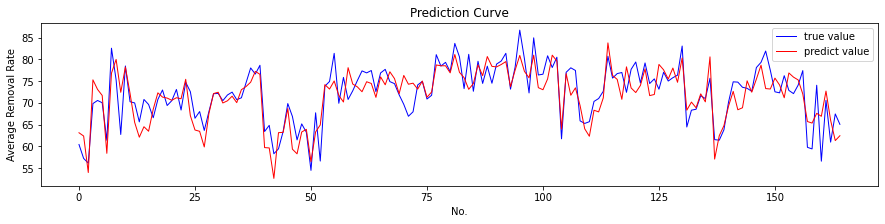

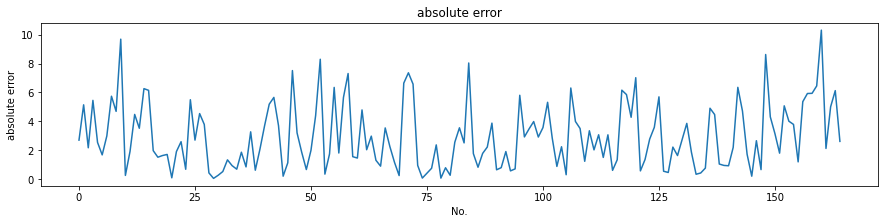

In [136]:
# h_dim1&h_dim2&epochs_layer&epochs_whole&batch_size 256&64&100&200&50 11.53（best） 256&64&100&200&200 12.37
epochs_layer, epochs_whole, batch_size, origin_dim, h_dim1, h_dim2 = 100, 200, 20, 256, 20, 15

stacked_sae = sae_train_and_test(features_seg_train, features_seg_test, Y_train, Y_test, epochs_layer=epochs_layer, epochs_whole=epochs_whole, batch_size=batch_size, origin_dim=origin_dim, h_dim1=h_dim1, h_dim2=h_dim2)

In [137]:
# 提取sae的压缩特征，训练集
sae_features_train = stacked_sae.features_layer.predict(features_seg_train)
fea_col_name = [f'sae_features_{i}' for i in range(0,sae_features_train.shape[1])]
with open('./data phm 2016/wafer_id_train_seg.list', 'rb') as f:
    wafer_id_train = pickle.load(f)
df_sae_features_train = pd.DataFrame(sae_features_train, columns=fea_col_name, index=wafer_id_train)
df_sae_features_train.index.set_names('WAFER_ID', inplace=True)
df_sae_features_train.to_csv('./data phm 2016/conv1d_sae_features_train.csv', index=True)

In [138]:
# 提取sae的压缩特征，测试集
sae_features_test = stacked_sae.features_layer.predict(features_seg_test)
fea_col_name = [f'sae_features_{i}' for i in range(0,sae_features_test.shape[1])]
with open('./data phm 2016/wafer_id_test_modeI_chamber4.list', 'rb') as f:
    wafer_id_test = pickle.load(f)
df_sae_features_test = pd.DataFrame(sae_features_test, columns=fea_col_name, index=wafer_id_test)
df_sae_features_test.index.set_names('WAFER_ID', inplace=True)
df_sae_features_test.to_csv('./data phm 2016/conv1d_sae_features_test.csv', index=True)

# 4.2 时段BiLSTM + SAE

In [227]:
n_epoch_all = [200, 100, 100, 150, 150]
batch_size_all = [200, 50, 200, 50, 100]

# best n_epoch&batch_size 200&200 11.56
# best n_epoch&batch_size 100&50 11.29
# best n_epoch&batch_size 100&200 13.98
# best n_epoch&batch_size 150&50 10.89
# best n_epoch&batch_size 150&100 9.88

for i in range(0,5):
    X_train = Train_seg_X[f'seg_{i}']
    X_test = Test_seg_X[f'seg_{i}']

    Y_train = np.reshape(Train_seg_Y[f'seg_{i}'], (-1,1))
    Y_test = np.reshape(Test_seg_Y[f'seg_{i}'], (-1,1))

    n_epoch = [n_epoch_all[i]]
    batch_size = [batch_size_all[i]]
    grid = ParameterGrid(dict(n_epoch=n_epoch, batch_size=batch_size))

    for params in grid:
        model_biLSTM = init_biLSTM_model(max_batch_length=max_batch_length[i], variable_number=variable_number, learning_rate=0.001, print_model=False)

        print('------------\n')
        print(params)
        fit_and_pre(model_biLSTM, X_train, Y_train, X_test, Y_test, verbose=0, show_figure=False, **params)

    layer_biLstm2 = model_biLSTM.get_layer('biLSTM2').output
    intermediate_layer_model = Model(inputs=model_biLSTM.input, outputs=layer_biLstm2)
    # pre train and test for 2nd hidden layer
    biLstm2_output_train = intermediate_layer_model.predict(X_train)
    biLstm2_output_test = intermediate_layer_model.predict(X_test)
    
    model_biLSTM.save(f'./save_model/segment_{i}_model_biLSTM.h5')
    pickle.dump(biLstm2_output_train, open(f'./data phm 2016/biLSTM_output_train_segment_{i}.array', 'wb'))
    pickle.dump(biLstm2_output_test, open(f'./data phm 2016/biLSTM_output_test_segment_{i}.array', 'wb'))

------------

{'batch_size': 200, 'n_epoch': 200}
Train Set Fit result:
MSE:  4.230055762418278
RMSE:  2.0567099363834167
MAE:  1.5658471515344412
R^2:  0.9044486565906332
max absolute error:  8.462013537597642
min absolute error:  0.0009418334960997754
mean absolute error:  1.5658471515344412


Test Set Prediction result:
MSE:  19.094067803566016
RMSE:  4.369675938049184
MAE:  3.2813510011615197
R^2:  0.5368178160508245
max absolute error:  18.463383264160157
min absolute error:  0.021740722656232947
mean absolute error:  3.2813510011615197


------------

{'batch_size': 50, 'n_epoch': 100}
Train Set Fit result:
MSE:  5.570118003011464
RMSE:  2.3601097438491
MAE:  1.7961597969083865
R^2:  0.8741784297821706
max absolute error:  10.712954992675797
min absolute error:  0.0029193481443314795
mean absolute error:  1.7961597969083865


Test Set Prediction result:
MSE:  11.778051443388565
RMSE:  3.431916584561543
MAE:  2.633079229292424
R^2:  0.7142890846341501
max absolute error:  15.56727

In [126]:
# 拼接时段特征
list_tmp = []
for i in range(0,5):
    features_seg_i = pickle.load(open(f'./data phm 2016/biLSTM_output_train_segment_{i}.array', 'rb'))
    list_tmp.append(features_seg_i)
features_seg_train = np.hstack(list_tmp)

list_tmp = []
for i in range(0,5):
    features_seg_i = pickle.load(open(f'./data phm 2016/biLSTM_output_test_segment_{i}.array', 'rb'))
    list_tmp.append(features_seg_i)
features_seg_test = np.hstack(list_tmp)

print('Features shape of Train set and Test set: ', features_seg_train.shape, features_seg_test.shape)

Features shape of Train set and Test set:  (797, 400) (165, 400)


Pre training:
level: 0
Model: "model_170"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 400)]             0         
_________________________________________________________________
dense_144 (Dense)            (None, 256)               102656    
_________________________________________________________________
dense_145 (Dense)            (None, 400)               102800    
Total params: 205,456
Trainable params: 205,456
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 - 0s - loss: 0.1250
Epoch 2/100
16/16 - 0s - loss: 0.1249
Epoch 3/100
16/16 - 0s - loss: 0.1249
Epoch 4/100
16/16 - 0s - loss: 0.1248
Epoch 5/100
16/16 - 0s - loss: 0.1247
Epoch 6/100
16/16 - 0s - loss: 0.1247
Epoch 7/100
16/16 - 0s - loss: 0.1246
Epoch 8/100
16/16 - 0s - loss: 0.1246
Epoch 9/100
16/16 - 0s - loss: 0.1245
Epoch 10/100
16/

16/16 - 0s - loss: 0.0574
Epoch 73/100
16/16 - 0s - loss: 0.0573
Epoch 74/100
16/16 - 0s - loss: 0.0573
Epoch 75/100
16/16 - 0s - loss: 0.0573
Epoch 76/100
16/16 - 0s - loss: 0.0573
Epoch 77/100
16/16 - 0s - loss: 0.0573
Epoch 78/100
16/16 - 0s - loss: 0.0573
Epoch 79/100
16/16 - 0s - loss: 0.0573
Epoch 80/100
16/16 - 0s - loss: 0.0573
Epoch 81/100
16/16 - 0s - loss: 0.0573
Epoch 82/100
16/16 - 0s - loss: 0.0573
Epoch 83/100
16/16 - 0s - loss: 0.0573
Epoch 84/100
16/16 - 0s - loss: 0.0573
Epoch 85/100
16/16 - 0s - loss: 0.0573
Epoch 86/100
16/16 - 0s - loss: 0.0573
Epoch 87/100
16/16 - 0s - loss: 0.0573
Epoch 88/100
16/16 - 0s - loss: 0.0573
Epoch 89/100
16/16 - 0s - loss: 0.0572
Epoch 90/100
16/16 - 0s - loss: 0.0572
Epoch 91/100
16/16 - 0s - loss: 0.0572
Epoch 92/100
16/16 - 0s - loss: 0.0572
Epoch 93/100
16/16 - 0s - loss: 0.0572
Epoch 94/100
16/16 - 0s - loss: 0.0572
Epoch 95/100
16/16 - 0s - loss: 0.0572
Epoch 96/100
16/16 - 0s - loss: 0.0572
Epoch 97/100
16/16 - 0s - loss: 0.0572

Epoch 44/100
16/16 - 0s - loss: 0.0105
Epoch 45/100
16/16 - 0s - loss: 0.0105
Epoch 46/100
16/16 - 0s - loss: 0.0105
Epoch 47/100
16/16 - 0s - loss: 0.0105
Epoch 48/100
16/16 - 0s - loss: 0.0105
Epoch 49/100
16/16 - 0s - loss: 0.0105
Epoch 50/100
16/16 - 0s - loss: 0.0105
Epoch 51/100
16/16 - 0s - loss: 0.0105
Epoch 52/100
16/16 - 0s - loss: 0.0105
Epoch 53/100
16/16 - 0s - loss: 0.0105
Epoch 54/100
16/16 - 0s - loss: 0.0105
Epoch 55/100
16/16 - 0s - loss: 0.0105
Epoch 56/100
16/16 - 0s - loss: 0.0105
Epoch 57/100
16/16 - 0s - loss: 0.0105
Epoch 58/100
16/16 - 0s - loss: 0.0105
Epoch 59/100
16/16 - 0s - loss: 0.0105
Epoch 60/100
16/16 - 0s - loss: 0.0105
Epoch 61/100
16/16 - 0s - loss: 0.0105
Epoch 62/100
16/16 - 0s - loss: 0.0105
Epoch 63/100
16/16 - 0s - loss: 0.0105
Epoch 64/100
16/16 - 0s - loss: 0.0105
Epoch 65/100
16/16 - 0s - loss: 0.0104
Epoch 66/100
16/16 - 0s - loss: 0.0104
Epoch 67/100
16/16 - 0s - loss: 0.0104
Epoch 68/100
16/16 - 0s - loss: 0.0104
Epoch 69/100
16/16 - 0s -

Epoch 85/200
16/16 - 0s - loss: 1.0130 - val_loss: 13.6938
Epoch 86/200
16/16 - 0s - loss: 1.0222 - val_loss: 13.7073
Epoch 87/200
16/16 - 0s - loss: 1.0491 - val_loss: 13.5814
Epoch 88/200
16/16 - 0s - loss: 0.9481 - val_loss: 14.0107
Epoch 89/200
16/16 - 0s - loss: 0.9837 - val_loss: 13.5005
Epoch 90/200
16/16 - 0s - loss: 0.9043 - val_loss: 13.5371
Epoch 91/200
16/16 - 0s - loss: 0.9398 - val_loss: 13.7586
Epoch 92/200
16/16 - 0s - loss: 1.0127 - val_loss: 13.4657
Epoch 93/200
16/16 - 0s - loss: 1.2324 - val_loss: 14.3207
Epoch 94/200
16/16 - 0s - loss: 1.1799 - val_loss: 14.1328
Epoch 95/200
16/16 - 0s - loss: 0.9716 - val_loss: 13.4466
Epoch 96/200
16/16 - 0s - loss: 0.9295 - val_loss: 13.5681
Epoch 97/200
16/16 - 0s - loss: 0.9586 - val_loss: 13.5576
Epoch 98/200
16/16 - 0s - loss: 0.9385 - val_loss: 13.8362
Epoch 99/200
16/16 - 0s - loss: 1.1842 - val_loss: 14.0242
Epoch 100/200
16/16 - 0s - loss: 1.0326 - val_loss: 13.7010
Epoch 101/200
16/16 - 0s - loss: 0.9753 - val_loss: 13.

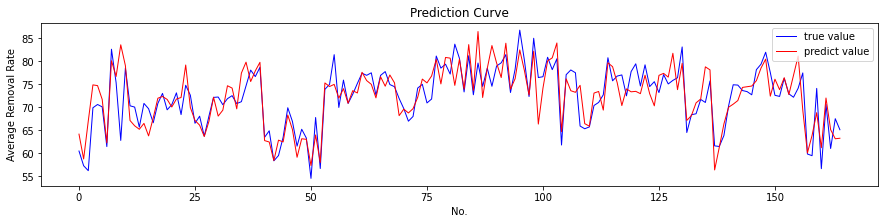

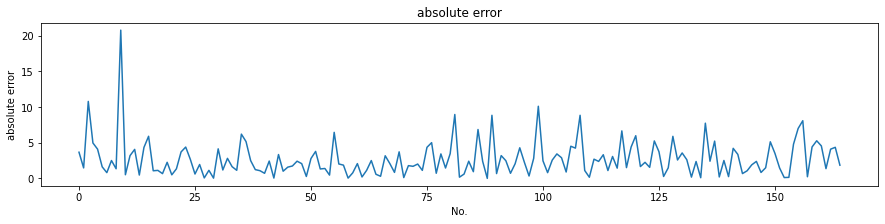

In [127]:
# h_dim1&h_dim2&epochs_layer&epochs_whole&batch_size 256&64&100&200&50 11.53（best） 256&64&100&200&200 12.37

epochs_layer, epochs_whole, batch_size, origin_dim, h_dim1, h_dim2 = 100, 200, 50, 400, 256, 64

stacked_sae = sae_train_and_test(features_seg_train, features_seg_test, Y_train, Y_test, epochs_layer=epochs_layer, epochs_whole=epochs_whole, batch_size=batch_size, origin_dim=origin_dim, h_dim1=h_dim1, h_dim2=h_dim2)

In [128]:
# 提取sae的压缩特征，训练集
sae_features_train = stacked_sae.features_layer.predict(features_seg_train)
fea_col_name = [f'sae_features_{i}' for i in range(0,sae_features_train.shape[1])]
with open('./data phm 2016/wafer_id_train_seg.list', 'rb') as f:
    wafer_id_train = pickle.load(f)
df_sae_features_train = pd.DataFrame(sae_features_train, columns=fea_col_name, index=wafer_id_train)
df_sae_features_train.index.set_names('WAFER_ID', inplace=True)
df_sae_features_train.to_csv('./data phm 2016/biLSTM_sae_features_train.csv', index=True)

In [129]:
# 提取sae的压缩特征，测试集
sae_features_test = stacked_sae.features_layer.predict(features_seg_test)
fea_col_name = [f'sae_features_{i}' for i in range(0,sae_features_test.shape[1])]
with open('./data phm 2016/wafer_id_test_modeI_chamber4.list', 'rb') as f:
    wafer_id_test = pickle.load(f)
df_sae_features_test = pd.DataFrame(sae_features_test, columns=fea_col_name, index=wafer_id_test)
df_sae_features_test.index.set_names('WAFER_ID', inplace=True)
df_sae_features_test.to_csv('./data phm 2016/biLSTM_sae_features_test.csv', index=True)

# 4.3 时段LSTM+SAE

In [17]:
# segment0～3一起保存，segment4单独保存
n_epoch_all = [200, 200, 150, 200]
batch_size_all = [50, 200, 100, 50]

for i in range(0,4):
    X_train = Train_seg_X[f'seg_{i}']
    X_test = Test_seg_X[f'seg_{i}']

    Y_train = np.reshape(Train_seg_Y[f'seg_{i}'], (-1,1))
    Y_test = np.reshape(Test_seg_Y[f'seg_{i}'], (-1,1))
    
    n_epoch = [n_epoch_all[i]]
    batch_size = [batch_size_all[i]]
    grid = ParameterGrid(dict(n_epoch=n_epoch, batch_size=batch_size))

    for params in grid:
        model_lstm = init_LSTM_model(max_batch_length=max_batch_length[i], variable_number=variable_number, learning_rate=0.001, print_model=False)
    
        print('------------\n')
        print(params)
        fit_and_pre(model_lstm, X_train, Y_train, X_test, Y_test, verbose=0, show_figure=False) # batch_size最好的结果
    
    
    layer_lstm2 = model_lstm.get_layer('lstm2').output
    intermediate_layer_model = Model(inputs=model_lstm.input, outputs=layer_lstm2)

    # pre train and test for 2nd hidden layer
    lstm2_output_train = intermediate_layer_model.predict(X_train)
    lstm2_output_test = intermediate_layer_model.predict(X_test)
    
    model_lstm.save(f'./save_model/segment_{i}_model_lstm.h5')
    pickle.dump(lstm2_output_train, open(f'./data phm 2016/lstm_output_train_segment_{i}.array', 'wb'))
    pickle.dump(lstm2_output_test, open(f'./data phm 2016/lstm_output_test_segment_{i}.array', 'wb'))

------------

{'batch_size': 100, 'n_epoch': 200}
Train Set Fit result:
MSE:  44.2692566225679
RMSE:  6.653514606774971
MAE:  5.232770008518885
R^2:  1.6269383141587213e-05
max absolute error:  19.65476408691405
min absolute error:  0.0009618286131427567
mean absolute error:  5.232770008518885


Test Set Prediction result:
MSE:  41.95662568363734
RMSE:  6.47739343282754
MAE:  5.021574366270123
R^2:  -0.017780062122529916
max absolute error:  18.57881408691405
min absolute error:  0.013385913085954826
mean absolute error:  5.021574366270123




In [130]:
# 拼接时段特征
list_tmp = []
for i in range(0,5):
    features_seg_i = pickle.load(open(f'./data phm 2016/lstm_output_train_segment_{i}.array', 'rb'))
    list_tmp.append(features_seg_i)
features_seg_train = np.hstack(list_tmp)

list_tmp = []
for i in range(0,5):
    features_seg_i = pickle.load(open(f'./data phm 2016/lstm_output_test_segment_{i}.array', 'rb'))
    list_tmp.append(features_seg_i)
features_seg_test = np.hstack(list_tmp)

print('Features shape of Train set and Test set: ', features_seg_train.shape, features_seg_test.shape)

Features shape of Train set and Test set:  (797, 180) (165, 180)


Pre training:
level: 0
Model: "model_190"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 180)]             0         
_________________________________________________________________
dense_160 (Dense)            (None, 20)                3620      
_________________________________________________________________
dense_161 (Dense)            (None, 180)               3780      
Total params: 7,400
Trainable params: 7,400
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 - 0s - loss: 748.8727
Epoch 2/100
16/16 - 0s - loss: 748.7874
Epoch 3/100
16/16 - 0s - loss: 748.7005
Epoch 4/100
16/16 - 0s - loss: 748.6124
Epoch 5/100
16/16 - 0s - loss: 748.5233
Epoch 6/100
16/16 - 0s - loss: 748.4336
Epoch 7/100
16/16 - 0s - loss: 748.3428
Epoch 8/100
16/16 - 0s - loss: 748.2509
Epoch 9/100
16/16 - 0s - loss: 748.1581
Ep

16/16 - 0s - loss: 613.0223
Epoch 65/100
16/16 - 0s - loss: 612.8835
Epoch 66/100
16/16 - 0s - loss: 612.7451
Epoch 67/100
16/16 - 0s - loss: 612.6054
Epoch 68/100
16/16 - 0s - loss: 612.4662
Epoch 69/100
16/16 - 0s - loss: 612.3259
Epoch 70/100
16/16 - 0s - loss: 612.1854
Epoch 71/100
16/16 - 0s - loss: 612.0440
Epoch 72/100
16/16 - 0s - loss: 611.9026
Epoch 73/100
16/16 - 0s - loss: 611.7612
Epoch 74/100
16/16 - 0s - loss: 611.6190
Epoch 75/100
16/16 - 0s - loss: 611.4768
Epoch 76/100
16/16 - 0s - loss: 611.3340
Epoch 77/100
16/16 - 0s - loss: 611.1920
Epoch 78/100
16/16 - 0s - loss: 611.0489
Epoch 79/100
16/16 - 0s - loss: 610.9057
Epoch 80/100
16/16 - 0s - loss: 610.7625
Epoch 81/100
16/16 - 0s - loss: 610.6187
Epoch 82/100
16/16 - 0s - loss: 610.4744
Epoch 83/100
16/16 - 0s - loss: 610.3304
Epoch 84/100
16/16 - 0s - loss: 610.1858
Epoch 85/100
16/16 - 0s - loss: 610.0408
Epoch 86/100
16/16 - 0s - loss: 609.8951
Epoch 87/100
16/16 - 0s - loss: 609.7490
Epoch 88/100
16/16 - 0s - los

Epoch 29/100
16/16 - 0s - loss: 45.9330
Epoch 30/100
16/16 - 0s - loss: 45.8630
Epoch 31/100
16/16 - 0s - loss: 45.7925
Epoch 32/100
16/16 - 0s - loss: 45.7216
Epoch 33/100
16/16 - 0s - loss: 45.6504
Epoch 34/100
16/16 - 0s - loss: 45.5789
Epoch 35/100
16/16 - 0s - loss: 45.5073
Epoch 36/100
16/16 - 0s - loss: 45.4363
Epoch 37/100
16/16 - 0s - loss: 45.3654
Epoch 38/100
16/16 - 0s - loss: 45.2945
Epoch 39/100
16/16 - 0s - loss: 45.2233
Epoch 40/100
16/16 - 0s - loss: 45.1517
Epoch 41/100
16/16 - 0s - loss: 45.0802
Epoch 42/100
16/16 - 0s - loss: 45.0082
Epoch 43/100
16/16 - 0s - loss: 44.9362
Epoch 44/100
16/16 - 0s - loss: 44.8639
Epoch 45/100
16/16 - 0s - loss: 44.7916
Epoch 46/100
16/16 - 0s - loss: 44.7191
Epoch 47/100
16/16 - 0s - loss: 44.6466
Epoch 48/100
16/16 - 0s - loss: 44.5737
Epoch 49/100
16/16 - 0s - loss: 44.5009
Epoch 50/100
16/16 - 0s - loss: 44.4280
Epoch 51/100
16/16 - 0s - loss: 44.3546
Epoch 52/100
16/16 - 0s - loss: 44.2813
Epoch 53/100
16/16 - 0s - loss: 44.2076


16/16 - 0s - loss: 6.6714 - val_loss: 10.9807
Epoch 74/200
16/16 - 0s - loss: 6.4870 - val_loss: 11.1380
Epoch 75/200
16/16 - 0s - loss: 6.4902 - val_loss: 10.4754
Epoch 76/200
16/16 - 0s - loss: 6.2922 - val_loss: 10.4826
Epoch 77/200
16/16 - 0s - loss: 6.3192 - val_loss: 10.5255
Epoch 78/200
16/16 - 0s - loss: 6.4987 - val_loss: 10.5261
Epoch 79/200
16/16 - 0s - loss: 6.3920 - val_loss: 10.5116
Epoch 80/200
16/16 - 0s - loss: 6.6276 - val_loss: 10.8022
Epoch 81/200
16/16 - 0s - loss: 6.4073 - val_loss: 10.6426
Epoch 82/200
16/16 - 0s - loss: 6.2392 - val_loss: 11.1674
Epoch 83/200
16/16 - 0s - loss: 6.5598 - val_loss: 10.6685
Epoch 84/200
16/16 - 0s - loss: 6.4841 - val_loss: 10.8792
Epoch 85/200
16/16 - 0s - loss: 6.2635 - val_loss: 10.6403
Epoch 86/200
16/16 - 0s - loss: 6.3288 - val_loss: 10.6083
Epoch 87/200
16/16 - 0s - loss: 6.2295 - val_loss: 10.5120
Epoch 88/200
16/16 - 0s - loss: 6.1368 - val_loss: 10.4734
Epoch 89/200
16/16 - 0s - loss: 6.1613 - val_loss: 10.4263
Epoch 90/2

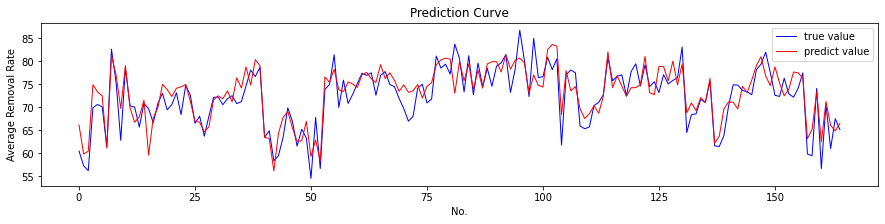

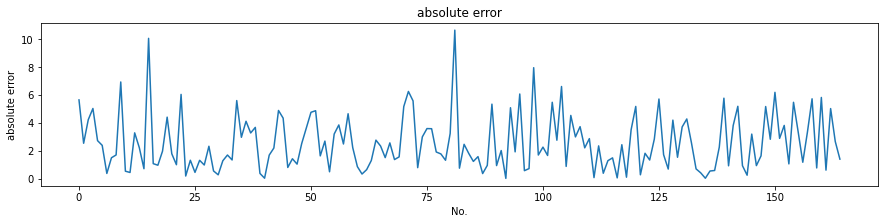

In [132]:
# h_dim1&h_dim2&epochs_layer&epochs_whole&batch_size  20&10&100&200&50

epochs_layer, epochs_whole, batch_size, origin_dim, h_dim1, h_dim2 = 100, 200, 50, 180, 20, 15

stacked_sae = sae_train_and_test(features_seg_train, features_seg_test, Y_train, Y_test, epochs_layer=epochs_layer, epochs_whole=epochs_whole, batch_size=batch_size, origin_dim=origin_dim, h_dim1=h_dim1, h_dim2=h_dim2)

In [133]:
# 提取sae的压缩特征，训练集
sae_features_train = stacked_sae.features_layer.predict(features_seg_train)
fea_col_name = [f'sae_features_{i}' for i in range(0,sae_features_train.shape[1])]
with open('./data phm 2016/wafer_id_train_seg.list', 'rb') as f:
    wafer_id_train = pickle.load(f)
df_sae_features_train = pd.DataFrame(sae_features_train, columns=fea_col_name, index=wafer_id_train)
df_sae_features_train.index.set_names('WAFER_ID', inplace=True)
df_sae_features_train.to_csv('./data phm 2016/LSTM_sae_features_train.csv', index=True)

In [134]:
# 提取sae的压缩特征，测试集
sae_features_test = stacked_sae.features_layer.predict(features_seg_test)
fea_col_name = [f'sae_features_{i}' for i in range(0,sae_features_test.shape[1])]
with open('./data phm 2016/wafer_id_test_modeI_chamber4.list', 'rb') as f:
    wafer_id_test = pickle.load(f)
df_sae_features_test = pd.DataFrame(sae_features_test, columns=fea_col_name, index=wafer_id_test)
df_sae_features_test.index.set_names('WAFER_ID', inplace=True)
df_sae_features_test.to_csv('./data phm 2016/LSTM_sae_features_test.csv', index=True)